In [1]:
import os
import optuna
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import positron_angle_optuna_pipeline
from pioneerml.optuna import OptunaStudyManager

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")

# Set up Optuna storage
optuna_manager = OptunaStudyManager(
    project_root=PROJECT_ROOT,
    study_name="positron_angle",
)
optuna_storage = optuna_manager.resolve_storage()
print(f"Using Optuna storage: {optuna_storage}")



Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default
Using Optuna storage: sqlite:////home/jack/python_projects/pioneerML/.optuna/positron_angle.db


In [ ]:
# Run (or reuse) the Optuna + training pipeline

file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')

# TODO: Angle data is NOT currently in mainTimeGroups files.
#       angle_targets_pattern is REQUIRED until angles are added to the data format.
#       Update this pattern to match your angle target files:
angle_targets_pattern = str(Path(PROJECT_ROOT) / 'data' / 'angleTargets_*.npy')  # TODO: Update this pattern

build_params = {
    # Data loading parameters
    'file_pattern': file_pattern,
    'angle_targets_pattern': angle_targets_pattern,  # REQUIRED: TODO - remove once angles are in mainTimeGroups
    'max_files': 1,              # Limit number of files to load
    'limit_groups': 1000,       # Cap total groups for quicker iterations
    'min_hits': 2,
    # Datamodule parameters
    'batch_size': 128,
    'num_workers': None,         # None = auto-detect (uses #CPU cores - 1)
                                 # Set to 0 to disable multiprocessing
                                 # Set to a specific number to override
    'val_split': 0.15,
    'seed': 42,
}

run = positron_angle_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params=build_params,
    run_hparam_search_params={
        'n_trials': 1,  # set >0 to add trials; 0 to reuse previous best if storage has it
        'max_epochs': 1,             # epochs per trial during search
        'limit_train_batches': 0.4,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
        'storage': optuna_storage,
        'study_name': 'positron_angle',
    },
    train_best_model_params={
        'max_epochs': 5,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 6, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: positron_angle_optuna_pipeline.
Caching is disabled by default for positron_angle_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_positron_angle_datamodule has started.


[build_positron_angle_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_positron_angle_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_positron_angle_datamodule] Loading angle targets from: None
[build_positron_angle_datamodule] Limiting to 1 files (from 11 total files found, max_files=1)
[build_positron_angle_datamodule] Loaded 1000 groups from 1 files with angle targets
[build_positron_angle_datamodule] Loaded 1000 groups. Building datamodule...


Step build_positron_angle_datamodule has finished in 0.346s.
Step run_positron_angle_hparam_search has started.


[run_positron_angle_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_positron_angle_hparam_search] CUDA devices: 1
[run_positron_angle_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_positron_angle_hparam_search] Dataset sizes - Train: 850, Val: 150
[run_positron_angle_hparam_search] Starting Optuna search with 1 trials, 1 epochs per trial...
[I 2025-12-07 16:22:16,248] Using an existing study with name 'positron_angle' instead of creating a new one.
[run_positron_angle_hparam_search] Starting Optuna study (storage=sqlite:////home/jack/python_projects/pioneerML/.optuna/positron_angle.db, name=positron_angle)...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_positron_angle_hparam_search] Trial 1/1 (cumulative 4/4) starting...
[run_positron_angle_hparam_search] Trial 1 params: batch_size=32, hidden=128 (from 128), heads=8, layers=4, dropout=0.1764, lr=0.000225, weight_decay=0.000020
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_positron_angle_hparam_search] Trial 1 training 1 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PositronAngleModel │  929 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss            │      0 │ train │     0 │
└───┴─────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 929 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 929 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 78                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[run_positron_angle_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_positron_angle_hparam_search] Trial 1 completed with score: 0.078308


[I 2025-12-07 16:22:20,855] Trial 3 finished with value: 0.0783077140912901 and parameters: {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.17639081568290949, 'lr': 0.00022543289955328212, 'weight_decay': 2.0169748586837032e-05}. Best is trial 3 with value: 0.0783077140912901.


[run_positron_angle_hparam_search] Optuna search complete! Best score: 0.078308
[run_positron_angle_hparam_search] Best params: {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.17639081568290949, 'lr': 0.00022543289955328212, 'weight_decay': 2.0169748586837032e-05}


Step run_positron_angle_hparam_search has finished in 4.808s.
Step train_best_positron_angle_regressor has started.


[train_best_positron_angle_regressor] Starting final model training...
[train_best_positron_angle_regressor] Dataset sizes - Train: 850, Val: 150
[train_best_positron_angle_regressor] Using GPU: NVIDIA GeForce RTX 5070
[train_best_positron_angle_regressor] CUDA devices: 1
[train_best_positron_angle_regressor] Enabled Tensor Core optimization (medium precision)
[train_best_positron_angle_regressor] Training configuration:
[train_best_positron_angle_regressor]   max_epochs: 5
[train_best_positron_angle_regressor]   early_stopping: True
[train_best_positron_angle_regressor]   early_stopping_patience: 6
[train_best_positron_angle_regressor] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PositronAngleModel │  929 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss            │      0 │ train │     0 │
└───┴─────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 929 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 929 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 78                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 9.051
Metric val_loss improved by 5.977 >= min_delta = 0.0. New best score: 3.074
Metric val_loss improved by 0.562 >= min_delta = 0.0. New best score: 2.513
Metric val_loss improved by 0.753 >= min_delta = 0.0. New best score: 1.759
Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.747
`Trainer.fit` stopped: `max_epochs=5` reached.


[train_best_positron_angle_regressor] Training complete! Final epoch: 6


Step train_best_positron_angle_regressor has finished in 14.519s.
Step collect_positron_angle_predictions has started.
Step collect_positron_angle_predictions has finished in 1.986s.
Pipeline run has finished in 24.168s.
Run name: positron_angle_optuna_pipeline-2025_12_07-21_22_14_990034
Run status: completed


In [3]:
# Load artifacts from the pipeline run
trained_module = load_step_output(run, "train_best_positron_angle_regressor")
datamodule = load_step_output(run, "build_positron_angle_datamodule")
predictions = load_step_output(run, "collect_positron_angle_predictions", index=0)
targets = load_step_output(run, "collect_positron_angle_predictions", index=1)
best_params = load_step_output(run, "run_positron_angle_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))



Loaded module on cpu; validation samples: 150
Best params from Optuna: {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.17639081568290949, 'lr': 0.00022543289955328212, 'weight_decay': 2.0169748586837032e-05, 'best_score': 0.0783077140912901, 'n_trials': 4} {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.17639081568290949, 'lr': 0.00022543289955328212, 'weight_decay': 2.0169748586837032e-05, 'best_score': 0.0783077140912901, 'n_trials': 4}
Epochs actually run: 6 6


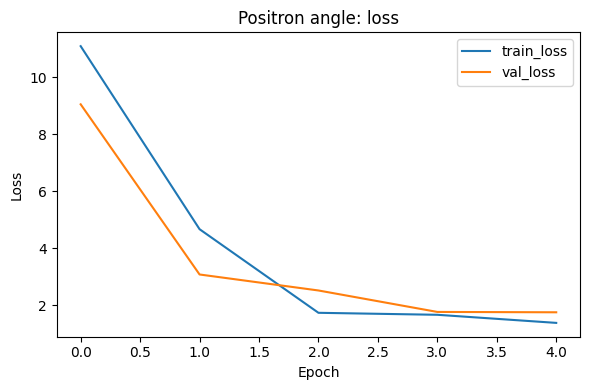

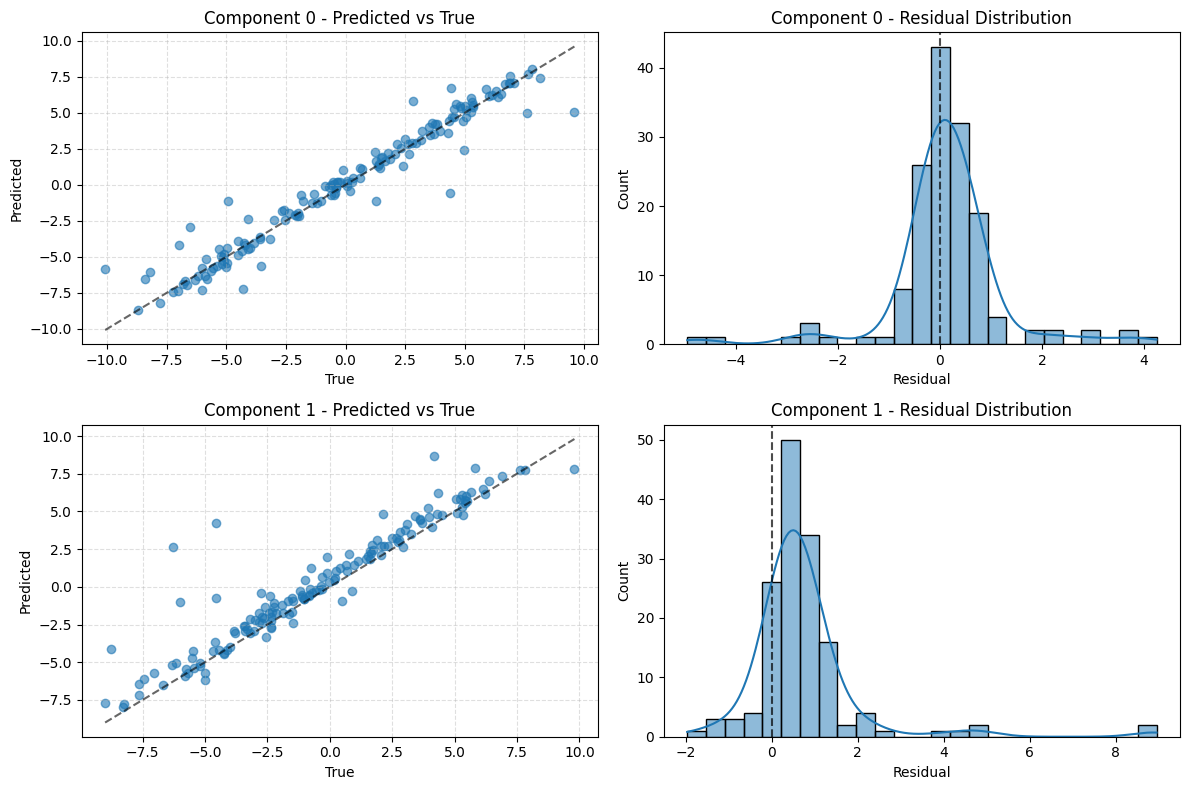

In [4]:
from pioneerml.evaluation.plots import plot_loss_curves, plot_regression_diagnostics

# Loss curves
plot_loss_curves(trained_module, title="Positron angle: loss", show=True)

# Regression diagnostics
plot_regression_diagnostics(predictions=predictions, targets=targets, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [5]:
from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now

# Build metadata and save model + metadata together
save_ts = timestamp_now()

meta = TrainingMetadata(
    model_type="PositronAngleModel",
    timestamp=save_ts,
    run_name=run.name if 'run' in locals() else None,
    best_hyperparameters=best_params,
    best_score=best_params.get('best_score') if isinstance(best_params, dict) else None,
    n_trials=best_params.get('n_trials') if isinstance(best_params, dict) else None,
    training_config=getattr(trained_module, 'training_config', {}),
    epochs_run=getattr(trained_module, 'final_epochs_run', None),
    dataset_info={
        'train_size': len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        'val_size': len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        'task': 'regression',
    },
    model_architecture={
        'hidden': best_params.get('hidden') if isinstance(best_params, dict) else None,
        'heads': best_params.get('heads') if isinstance(best_params, dict) else None,
        'layers': best_params.get('layers') if isinstance(best_params, dict) else None,
        'dropout': best_params.get('dropout') if isinstance(best_params, dict) else None,
    },
    # Store link to Optuna DB instead of full history
    optuna_storage=optuna_storage,
    optuna_study_name=optuna_manager.study_name,
)

paths = save_model_and_metadata(
    model=trained_module.model,
    metadata=meta,
    state_dict_only=True,
)

print("Saved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now     │
│    2                                                                                             │
│    3 # Build metadata and save model + metadata together                                         │
│    4 save_ts = timestamp_now()                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'save_model_and_metadata' from 'pioneerml.metadata' 
(/home/jack/python_projects/pioneerML/src/pioneerml/metadata/__init__.py)